In [1]:
import numpy as np
import pandas as pd
import requests

#### Requirements
```
pip3 install pandas lxml
```

In [2]:
# Fetching data from BTS database

import zipfile
import io

def get_data_csv():
    years_interval = ["2015","2018"]
    req_header = {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
        "Accept-Encoding": "gzip, deflate, br",
        "Accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
        "Cache-Control": "no-cache",
        "Connection": "keep-alive",
        "Content-Type": "application/x-www-form-urlencoded",
        "Cookie": "ASPSESSIONIDCQCDRTCQ=FKGMOCEDMCDHINELAEGCEIKN",
        "Host": "www.transtats.bts.gov",
        "Origin": "https://www.transtats.bts.gov",
        "Pragma": "no-cache",
        "Referer": "https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time",
        "Upgrade-Insecure-Requests": "1",
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.139 Safari/537.36"
    }
    data_url = "https://www.transtats.bts.gov/DownLoad_Table.asp?Table_ID=236&Has_Group=3&Is_Zipped=0"
    pair_form_data = {
    "UserTableName":"On_Time_Performance",
    "DBShortName":"On_Time",
    "RawDataTable":"T_ONTIME",
    "sqlstr":\
            "SELECT YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_GROUP,DISTANCE,CANCELLED,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY \
            FROM T_ONTIME \
            WHERE (\
                DEST IN ('EWR','JFK','LGA') OR\
                ORIGIN IN ('EWR','JFK','LGA')\
            )\
            AND \
            Month BETWEEN 1 AND 12 AND \
            YEAR BETWEEN {} AND {}".format(years_interval[0],years_interval[1]),
    "varlist":"YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,CARRIER,TAIL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_GROUP,DISTANCE,CANCELLED,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY",
    }
    r = requests.post(data_url,
                      data=pair_form_data,
                      headers=req_header,
                     )
    z = zipfile.ZipFile(io.BytesIO(r.content))
    return pd.read_csv(io.BytesIO(z.read(z.infolist()[0])),
                       dtype={
                          "CRS_DEP_TIME":str,
                          "DEP_TIME":str,
                          "CRS_ARR_TIME":str,
                          "ARR_TIME":str,
                          "CANCELLED":bool,
                          "DIVERTED":bool},
                      usecols=list(range(24))
                      )

In [5]:
# scraping hourly weather data from wunderground.com

import lxml
from multiprocessing.dummy import Pool
from bs4 import BeautifulSoup

NYC_AIRPORTS = ["EWR","JFK","LGA"]
MIA_AIRPORTS = ["FLL","MIA"]

def wind_speed_conv(x):
    try:
        ret = 0.0 if x == "Calm" else float(x)
    except:
        ret = np.NaN
    return ret
DIR_ANGLE={
            "North": 0,"NNE": 1,"NE": 2,"ENE": 3,"East": 4,"ESE": 5,"SE": 6,"SSE": 7,
            "South": 8,"SSW": 9,"SW":10,"WSW":11,"West":12,"WNW":13,"NW":14,"NNW":15,
          }
def wind_dir_conv(x):
    return np.NaN if x not in DIR_ANGLE else 22.5*DIR_ANGLE[x]
def humidity_conv(x):
    try:
        ret = float(x.strip("%"))/100
    except:
        ret = np.NaN
    return ret
def precip_conv(x):
    try:
        ret = 0.0 if x == "N/A" else float(x)
    except:
        ret = 0.0
    return ret
def event_conv(x):
    return "".join(x.split("\t"))


def table_parser(pair):
    url, date, airport = pair
    content = requests.get(url).content
    def time_conv(x):
        return date + " " + x
    bs = BeautifulSoup(content, "html5lib")
    table_html = bs.find(id="obsTable")
    for unit_tag in table_html.find_all("span",class_="wx-unit"):
        unit_tag.decompose()
    table_df = pd.read_html(str(table_html), converters= \
                            {
                                "Time (EST)":time_conv,
                                "Time (EDT)":time_conv,
                                "Wind Speed":wind_speed_conv,
                                "Wind Dir":wind_dir_conv,
                                "Precip":precip_conv,
                                "Humidity":humidity_conv,
                                "Events":event_conv
                            })[0]
    table_df = table_df.drop(["Windchill", "Dew Point", "Gust Speed"],axis=1, errors="ignore")
    table_df.rename(columns={"Time (EST)":"Time", "Time (EDT)":"Time", "Temp.":"Temp"}, inplace=True)
    table_df["Time"] = pd.to_datetime(table_df["Time"])
    table_df.set_index("Time", inplace=True)
    table_df["Airport"] = airport
    return table_df

def weather_scraper(dates):
    # Run once. Slow to run.
    base_url = "https://www.wunderground.com/history/airport/K{}/{}/DailyHistory.html"
    
    pool = Pool(8)
    pairs = []
    for airport in NYC_AIRPORTS + MIA_AIRPORTS:
        for date in dates:
            date_str = date.strftime("%Y/%m/%d")
            url = base_url.format(airport, date_str)
            pairs.append((url, date_str, airport))
            
    weather_df_list = pool.map(table_parser, pairs)
    pool.close()
    pool.join()
            
    result = pd.concat(weather_df_list)
    result.to_csv("weather.csv")
    return result

In [51]:
weather = pd.read_csv("weather.csv", low_memory=False, parse_dates=["Time"], na_values=["-"], index_col="Time")
weather = weather.drop("Heat Index",axis=1)

condition_dict={
    "Clear":"Clear",
    "Mostly Cloudy":"Mostly Cloudy",
    "Partly Cloudy":"Partly Cloudy",
    "Scattered Clouds":"Scattered Clouds",
    "Overcast":"Overcast",
    "Light Snow":"Light Snow",
    "Light Rain":"Light Rain",
    "Snow":"Snow",
    "Light Drizzle":"Light Drizzle",
    "Rain":"Rain",
    "Fog":"Fog",
    "Light Freezing Drizzle":"Light Freezing Drizzle",
    "Light Freezing Rain":"Light Freezing Rain",
    "Heavy Rain":"Heavy Rain",
    "Thunderstorms and Rain":"Thunderstorm|Rain",
    "Heavy Snow":"Heavy Snow",
    "Light Ice Pellets":"Light Ice Pellets",
    "Blowing Snow":"Blowing Snow",
    "Haze":"Haze",
    "Ice Pellets":"Ice Pellets",
    "Light Thunderstorms and Rain":"Light Rain|Thunderstorm",
    "Heavy Thunderstorms and Rain":"Heavy Rain|Thunderstorm",
    "Thunderstorm":"Thunderstorm",
    "Mist":"Mist",
    "Light Rain Showers":"Light Rain Showers",
    "Unknown":"Unknown",
    "Shallow Fog":"Shallow Fog",
    "Heavy Ice Pellets":"Heavy Ice Pellets",
    "Heavy Thunderstorms with Ice Pellets":"Heavy Ice Pellets|Thunderstorm",
    "Squalls":"Squalls",
    "Patches of Fog":"Patches of Fog",
    "Smoke":"Smoke",
    "Light Freezing Fog":"Light Freezing Fog",
    "Funnel Cloud":"Funnel Cloud"
}
weather["Conditions"] = weather["Conditions"].apply(lambda x: condition_dict[x])

In [52]:
# handle weather with DST
new_weather_list = []
for a in NYC_AIRPORTS+MIA_AIRPORTS:
    weather_airport_idx = weather[weather["Airport"]==a].index
    weather_airport_tz_idx = weather_airport_idx.tz_localize('US/Eastern', ambiguous='infer')
    new_weather = weather[weather["Airport"]==a].set_index(weather_airport_tz_idx)
    new_weather_list.append(new_weather[~new_weather.index.duplicated()])
new_weather = pd.concat(new_weather_list)
    
new_weather.sort_index(inplace=True)

In [8]:
# raw_data = get_data_csv()
# raw_data.to_csv("data.csv", index=False)
raw_data = pd.read_csv("data.csv",dtype={
                          "CRS_DEP_TIME":str,
                          "DEP_TIME":str,
                          "CRS_ARR_TIME":str,
                          "ARR_TIME":str,
                          "CANCELLED":bool,
                          "DIVERTED":bool})
raw_data[["DEP_DELAY","ARR_DELAY"]] = raw_data[["DEP_DELAY","ARR_DELAY"]].fillna(0)

In [22]:
data = raw_data[~(raw_data["DIVERTED"] | raw_data["CANCELLED"])].drop(["CANCELLED","DIVERTED"], axis=1)

time_cols = ["CRS_DEP_TIME", "CRS_ARR_TIME"]
for col in time_cols:
    data.loc[data[col]=="2400",col] = "0000"
    data[col.rsplit("_",1)[0]+"_DATETIME"] = \
    pd.to_datetime(data["FL_DATE"]+" "+data[col], format="%Y-%m-%d %H%M")
    
# check if arrival time is after departure
data.loc[(data['CRS_ARR_DATETIME'] < data['CRS_DEP_DATETIME']), 'CRS_ARR_DATETIME'] += pd.Timedelta(days=1)
data['CRS_DEP_DATETIME'] = pd.DatetimeIndex(data["CRS_DEP_DATETIME"]).tz_localize("US/Eastern", ambiguous=False, errors="coerce")
data['CRS_ARR_DATETIME'] = pd.DatetimeIndex(data["CRS_ARR_DATETIME"]).tz_localize("US/Eastern", ambiguous=False, errors="coerce")

data["DEP_DATETIME"] = data["CRS_DEP_DATETIME"] + pd.to_timedelta(data["DEP_DELAY"], unit="m")
data["ARR_DATETIME"] = data["CRS_ARR_DATETIME"] + pd.to_timedelta(data["ARR_DELAY"], unit="m")
data = data[~(data[["DEP_DATETIME","ARR_DATETIME"]].isnull().any(axis=1))]

In [23]:
mia_data = data.drop(time_cols+["DEP_TIME", "ARR_TIME"],axis=1)
mia_data = mia_data[mia_data["DEST"].isin(MIA_AIRPORTS)]# | mia_data["ORIGIN"].isin(MIA_AIRPORTS)]
mia_data["date"] = pd.to_datetime(mia_data["FL_DATE"])
mia_data = mia_data.set_index("date").sort_index()

In [24]:
# weather_scraper(data.index.unique())

In [53]:
temp_df = pd.merge_asof(mia_data.sort_values("CRS_DEP_DATETIME"), new_weather, left_by=["ORIGIN"], right_by=["Airport"], left_on="CRS_DEP_DATETIME", right_index=True)
weather_flight_data = pd.merge_asof(temp_df.sort_values("CRS_ARR_DATETIME"), new_weather, left_by=["DEST"], right_by=["Airport"], left_on="CRS_ARR_DATETIME", right_index=True, suffixes=["_dep","_arr"])

In [251]:
weather_flight_data = pd.merge_asof(weather_flight_data.sort_values("CRS_DEP_DATETIME"),
                                    data[["ARR_DATETIME","TAIL_NUM","DEST","ARR_DELAY"]].sort_values("ARR_DATETIME"),
                                    left_by=["TAIL_NUM","ORIGIN"],
                                    right_by=["TAIL_NUM","DEST"],
                                    left_on="CRS_DEP_DATETIME",
                                    right_on="ARR_DATETIME",
                                    suffixes=("","_PREV"),
                                    allow_exact_matches=False)
weather_flight_data["PREV_ARR_LT_ONE_DAY"] = (weather_flight_data["CRS_DEP_DATETIME"] - weather_flight_data["ARR_DATETIME_PREV"] < pd.Timedelta(days=1)).astype(int)
weather_flight_data["PREV_ARR_LT_SIX_HOURS"] = (weather_flight_data["CRS_DEP_DATETIME"] - weather_flight_data["ARR_DATETIME_PREV"] < pd.Timedelta(hours=6)).astype(int)
weather_flight_data.drop(["ARR_DATETIME_PREV", "DEST_PREV"],axis=1, inplace=True)
weather_flight_data["ARR_DELAY_PREV"] = weather_flight_data["ARR_DELAY_PREV"].fillna(0)

In [27]:
print(weather_flight_data.head())
print (list(weather_flight_data))

   YEAR  QUARTER  MONTH  DAY_OF_MONTH  DAY_OF_WEEK     FL_DATE CARRIER  \
0  2015        1      1             1            4  2015-01-01      AA   
1  2015        1      1             1            4  2015-01-01      AA   
2  2015        1      1             1            4  2015-01-01      B6   
3  2015        1      1             1            4  2015-01-01      B6   
4  2015        1      1             1            4  2015-01-01      AA   

  TAIL_NUM ORIGIN DEST         ...          Events_arr  Humidity_arr  \
0   N3LLAA    JFK  MIA         ...                 NaN          0.91   
1   N3FKAA    EWR  MIA         ...                 NaN          0.82   
2   N766JB    EWR  FLL         ...                 NaN          0.91   
3   N708JB    LGA  FLL         ...                 NaN          0.91   
4   N3JYAA    LGA  MIA         ...                 NaN          0.82   

   Precip_arr  Pressure_arr  Temp_arr  Visibility_arr  Wind Dir_arr  \
0         0.0         30.19      72.0             5

### Exploratory Analysis



In [55]:
import matplotlib.pyplot as plt
%matplotlib inline

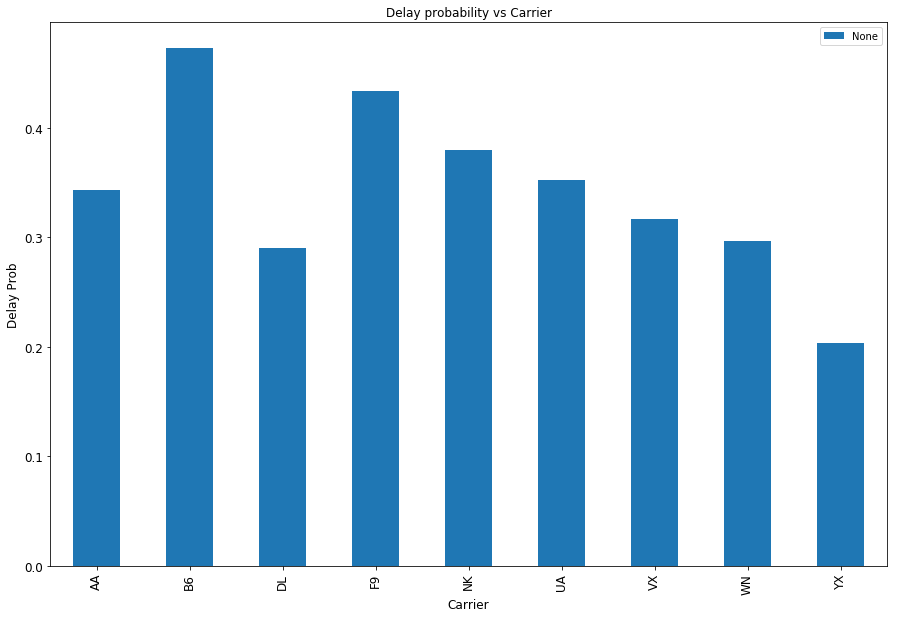

In [410]:
#weather_flight_data
carrier_prob = weather_flight_data[['CARRIER','ARR_DELAY']]\
                .groupby(['CARRIER'], group_keys=False)\
                .apply(lambda x: x[x['ARR_DELAY']>0].shape[0]/x.shape[0])
ax = carrier_prob.plot(kind='bar', title ="Delay probability vs Carrier", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Carrier", fontsize=12)
ax.set_ylabel("Delay Prob", fontsize=12)
plt.show()

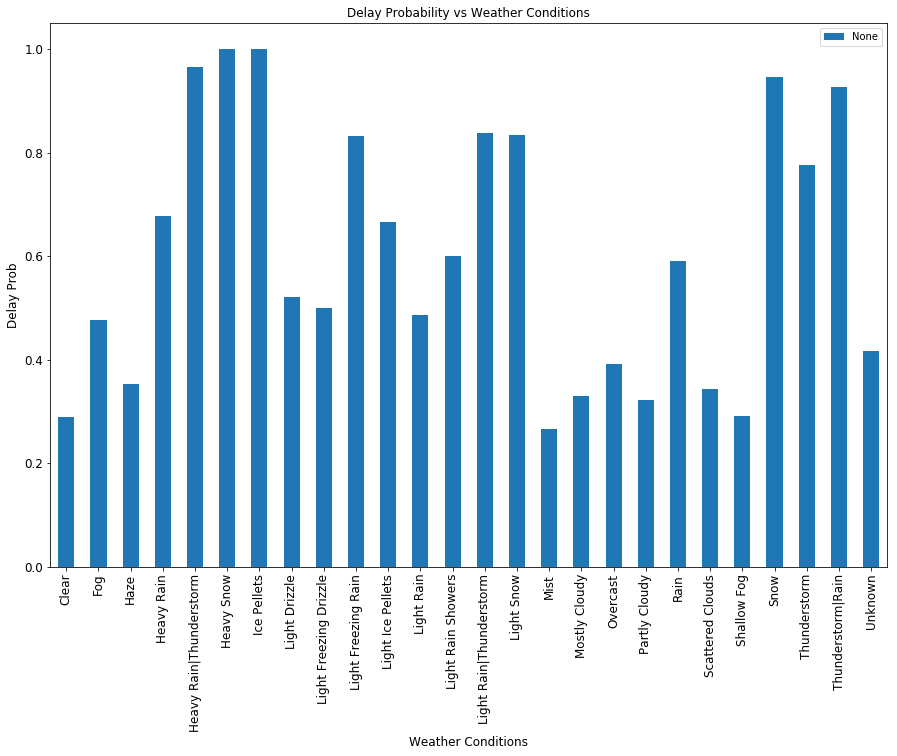

In [409]:
Conditions_arr_prob = weather_flight_data[['Conditions_dep','ARR_DELAY']]\
                .groupby(['Conditions_dep'], group_keys=False)\
                .apply(lambda x: x[x['ARR_DELAY']>0].shape[0]/x.shape[0])
ax = Conditions_arr_prob.plot(kind='bar', title ="Delay Probability vs Weather Conditions", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Weather Conditions", fontsize=12)
ax.set_ylabel("Delay Prob", fontsize=12)
plt.show()

In [411]:
from sklearn import preprocessing
def normalize(feature_list,feature_df):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    
    for f in feature_list:        
        x_scaled = min_max_scaler.fit_transform(feature_df[[f]].values.astype(float))
        feature_df[f]= pd.DataFrame(x_scaled)
        
    return feature_df

#['Month','Carrier','origin','Dest','distance']
all_df = weather_flight_data[["MONTH", "DAY_OF_WEEK", 'CARRIER', 'ORIGIN',
                    'DEST', 'DEP_DELAY','ARR_DELAY_GROUP', 'ARR_DELAY', 'CRS_ARR_DATETIME',
                    'CRS_DEP_DATETIME', 'Conditions_dep', 'Humidity_dep',
                    'Precip_dep', 'Pressure_dep', 'Temp_dep', 'Visibility_dep',
                    'Wind Dir_dep', 'Wind Speed_dep',  'Conditions_arr',
                    'Humidity_arr', 'Precip_arr', 'Pressure_arr', 'Temp_arr',
                    'Visibility_arr', 'Wind Dir_arr', 'Wind Speed_arr',
                    "ARR_DELAY_PREV","PREV_ARR_LT_ONE_DAY","PREV_ARR_LT_SIX_HOURS"]]
all_df = all_df.dropna(axis=0, how='any', subset=set(all_df.columns) - set(["Wind Dir_arr", "Wind Dir_dep"]))
y_df = all_df['ARR_DELAY_GROUP'].reset_index(drop=True)
all_df = all_df.drop(['ARR_DELAY_GROUP','ARR_DELAY'],axis=1).reset_index(drop=True)

def sincos(df,feature_list,freq_list):
    for feature, freq in zip(feature_list, freq_list):
        df[feature+"_SIN"] = np.sin(df[feature]/freq*2*np.pi).fillna(0)
        df[feature+"_COS"] = np.cos(df[feature]/freq*2*np.pi).fillna(0)
        
sincos(all_df,["MONTH", "DAY_OF_WEEK", "Wind Dir_arr", "Wind Dir_dep"],[12, 7, 360, 360])
all_df = all_df.drop(["MONTH","DAY_OF_WEEK", "Wind Dir_arr", "Wind Dir_dep"], axis=1)

norm_list = ['Pressure_dep','Pressure_arr','Temp_arr','Temp_dep','Visibility_dep','Visibility_arr']
feature_df = pd.get_dummies(all_df.drop(["Conditions_dep","Conditions_arr"],axis=1))
feature_df = normalize(norm_list,feature_df)
feature_df = pd.concat([
        feature_df,
        all_df["Conditions_dep"].str.get_dummies().add_prefix("Conditions_dep_"),
        all_df["Conditions_arr"].str.get_dummies().add_prefix("Conditions_arr_")
    ],
    axis=1)

feature_df['Wind_arr_SIN'] = feature_df['Wind Dir_arr_SIN'] * feature_df['Wind Speed_arr']
feature_df['Wind_arr_COS'] = feature_df['Wind Dir_arr_COS'] * feature_df['Wind Speed_arr']
feature_df['Wind_dep_SIN'] = feature_df['Wind Dir_dep_SIN'] * feature_df['Wind Speed_dep']
feature_df['Wind_dep_COS'] = feature_df['Wind Dir_dep_COS'] * feature_df['Wind Speed_dep']
feature_df['CRS_ARR_HOUR_SIN'] = np.sin(feature_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_ARR_HOUR_COS'] = np.cos(feature_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_DEP_HOUR_SIN'] = np.sin(feature_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
feature_df['CRS_DEP_HOUR_COS'] = np.cos(feature_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
dt = feature_df["CRS_DEP_DATETIME"].dt
time_of_day = 2*np.pi*(dt.hour*60+dt.minute)/3600
feature_df['CRS_DEP_TOD_SIN'] = np.sin(time_of_day)
feature_df['CRS_DEP_TOD_COS'] = np.cos(time_of_day)
feature_df = feature_df.drop(['CRS_ARR_DATETIME','CRS_DEP_DATETIME','DEP_DELAY', 'Wind Dir_arr', 'Wind Dir_dep','Wind Dir_arr_SIN', 'Wind Dir_dep_COS'],axis=1)

baseline_df = all_df[["CARRIER","MONTH_SIN","MONTH_COS","DAY_OF_WEEK_SIN","DAY_OF_WEEK_COS","CRS_ARR_DATETIME","CRS_DEP_DATETIME","DEST","ORIGIN"]]

baseline_df = pd.get_dummies(baseline_df)
# norm_list_baseline = ['DEP_DELAY']
# baseline_df = normalize(norm_list_baseline,baseline_df)
baseline_df['CRS_ARR_HOUR_SIN'] = np.sin(baseline_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_ARR_HOUR_COS'] = np.cos(baseline_df['CRS_ARR_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_DEP_HOUR_SIN'] = np.sin(baseline_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
baseline_df['CRS_DEP_HOUR_COS'] = np.cos(baseline_df['CRS_DEP_DATETIME'].dt.hour/24*2*np.pi)
baseline_df = baseline_df.drop(['CRS_ARR_DATETIME','CRS_DEP_DATETIME'],axis=1)

In [412]:
print(feature_df.columns)
print(baseline_df.columns)

Index(['Humidity_dep', 'Precip_dep', 'Pressure_dep', 'Temp_dep',
       'Visibility_dep', 'Wind Speed_dep', 'Humidity_arr', 'Precip_arr',
       'Pressure_arr', 'Temp_arr', 'Visibility_arr', 'Wind Speed_arr',
       'ARR_DELAY_PREV', 'ARR_DELAY_PREV', 'PREV_ARR_LT_ONE_DAY',
       'PREV_ARR_LT_SIX_HOURS', 'MONTH_SIN', 'MONTH_COS', 'DAY_OF_WEEK_SIN',
       'DAY_OF_WEEK_COS', 'Wind Dir_arr_COS', 'Wind Dir_dep_SIN', 'CARRIER_AA',
       'CARRIER_B6', 'CARRIER_DL', 'CARRIER_F9', 'CARRIER_NK', 'CARRIER_UA',
       'CARRIER_VX', 'CARRIER_WN', 'CARRIER_YX', 'ORIGIN_EWR', 'ORIGIN_JFK',
       'ORIGIN_LGA', 'DEST_FLL', 'DEST_MIA', 'Conditions_dep_Clear',
       'Conditions_dep_Fog', 'Conditions_dep_Haze',
       'Conditions_dep_Heavy Rain', 'Conditions_dep_Heavy Snow',
       'Conditions_dep_Ice Pellets', 'Conditions_dep_Light Drizzle',
       'Conditions_dep_Light Freezing Drizzle',
       'Conditions_dep_Light Freezing Rain',
       'Conditions_dep_Light Ice Pellets', 'Conditions_dep_Light R

In [413]:
print(y_df[y_df == -1].size)
print(y_df.size)

22297
86243


In [416]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
# train baseline
X_baseline = baseline_df.values
y_binary = (y_df >= 0).astype(int)
X_total_baseline, X_test_baseline, y_total_baseline, y_test_baseline = train_test_split(X_baseline, y_binary, test_size=0.1, random_state=42)
X_baseline, X_val_baseline, y_baseline, y_val_baseline = train_test_split(X_total_baseline, y_total_baseline, test_size=0.1, random_state=42)

In [417]:
print(y_binary[y_binary==0].size)

53763


In [418]:
clf = LinearSVC(random_state=0)
clf.fit(X_baseline, y_baseline)
pred_train_baseline = clf.predict(X_baseline)
pred_val_baseline = clf.predict(X_val_baseline)
pred_test_baseline = clf.predict(X_test_baseline)

acc_train_baseline = accuracy_score(y_baseline, pred_train_baseline)
acc_val_baseline = accuracy_score(y_val_baseline, pred_val_baseline)
acc_test_baseline = accuracy_score(y_test_baseline, pred_test_baseline)

prec_train_baseline = precision_score(y_baseline, pred_train_baseline)
prec_val_baseline = precision_score(y_val_baseline, pred_val_baseline)
prec_test_baseline = precision_score(y_test_baseline, pred_test_baseline)

F1_train_baseline = f1_score(y_baseline, pred_train_baseline)
F1_val_baseline = f1_score(y_val_baseline, pred_val_baseline)
F1_test_baseline = f1_score(y_test_baseline, pred_test_baseline)

print ("acc_train = ",acc_train_baseline)
print ("acc_val = ",acc_val_baseline)
print("acc_test = ",acc_test_baseline)

print('===============================')
print ("prec_train = ",prec_train_baseline)
print ("prec_val = ",prec_val_baseline)
print("prec_test = ",prec_test_baseline)

print('===============================')
print ("f1_train = ",F1_train_baseline)
print ("f1_val = ",F1_val_baseline)
print("f1_test = ",F1_test_baseline)


acc_train =  0.648892006413
acc_val =  0.651507343468
acc_test =  0.65368115942
prec_train =  0.583459357278
prec_val =  0.606164383562
prec_test =  0.599196787149
f1_train =  0.334824939658
f1_val =  0.343605920893
f1_test =  0.333110069212


In [419]:
X_binary = feature_df.values
y_binary = (y_df >= 0).astype(int)
X_total_binary, X_test_binary, y_total_binary, y_test_binary = train_test_split(X_binary, y_binary, test_size=0.1, random_state=42)
X, X_val_binary, y, y_val_binary = train_test_split(X_total_binary, y_total_binary, test_size=0.1, random_state=42)

In [420]:
clf_binary = LogisticRegression(random_state=0)
clf_binary.fit(X, y)
pred_train_binary = clf_binary.predict(X)
pred_val_binary = clf_binary.predict(X_val_binary)
pred_test_binary = clf_binary.predict(X_test_binary)


acc_train_binary = accuracy_score(y, pred_train_binary)
acc_val_binary = accuracy_score(y_val_binary, pred_val_binary)
acc_test_binary = accuracy_score(y_test_binary, pred_test_binary)

prec_train_binary = precision_score(y, pred_train_binary)
prec_val_binary = precision_score(y_val_binary, pred_val_binary)
prec_test_binary = precision_score(y_test_binary, pred_test_binary)

F1_train_binary = f1_score(y, pred_train_binary)
F1_val_binary = f1_score(y_val_binary, pred_val_binary)
F1_test_binary = f1_score(y_test_binary, pred_test_binary)

print ("acc_train = ",acc_train_binary)
print ("acc_val = ",acc_val_binary)
print("acc_test = ",acc_test_binary)

print('===============================')
print ("prec_train = ",prec_train_binary)
print ("prec_val = ",prec_val_binary)
print("prec_test = ",prec_test_binary)

print('===============================')
print ("f1_train = ",F1_train_binary)
print ("f1_val = ",F1_val_binary)
print("f1_test = ",F1_test_binary)

acc_train =  0.71432661475
acc_val =  0.713733573821
acc_test =  0.715710144928
prec_train =  0.681982654644
prec_val =  0.68987012987
prec_test =  0.687619961612
f1_train =  0.543382756727
f1_val =  0.544485444854
f1_test =  0.538924407672


In [421]:
clf_binary = LinearSVC(random_state=0)
clf_binary.fit(X, y)
pred_train_binary = clf_binary.predict(X)
pred_val_binary = clf_binary.predict(X_val_binary)
pred_test_binary = clf_binary.predict(X_test_binary)


acc_train_binary = accuracy_score(y, pred_train_binary)
acc_val_binary = accuracy_score(y_val_binary, pred_val_binary)
acc_test_binary = accuracy_score(y_test_binary, pred_test_binary)

prec_train_binary = precision_score(y, pred_train_binary)
prec_val_binary = precision_score(y_val_binary, pred_val_binary)
prec_test_binary = precision_score(y_test_binary, pred_test_binary)

F1_train_binary = f1_score(y, pred_train_binary)
F1_val_binary = f1_score(y_val_binary, pred_val_binary)
F1_test_binary = f1_score(y_test_binary, pred_test_binary)

print ("acc_train = ",acc_train_binary)
print ("acc_val = ",acc_val_binary)
print("acc_test = ",acc_test_binary)

print('===============================')
print ("prec_train = ",prec_train_binary)
print ("prec_val = ",prec_val_binary)
print("prec_test = ",prec_test_binary)

print('===============================')
print ("f1_train = ",F1_train_binary)
print ("f1_val = ",F1_val_binary)
print("f1_test = ",F1_test_binary)

acc_train =  0.689403916628
acc_val =  0.689384179335
acc_test =  0.687420289855
prec_train =  0.666642494561
prec_val =  0.669375
prec_test =  0.661658653846
f1_train =  0.458698201232
f1_val =  0.470459037997
f1_test =  0.449571253573


In [423]:
# predict multiclass
X = feature_df.values
y = y_df.values
X_total, X_test, y_total, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X, X_val, y, y_val = train_test_split(X_total, y_total, test_size=0.1, random_state=42)

In [197]:
#SVM predict multiclass
clf = LinearSVC(random_state=0)
clf.fit(X,  y)

pred_train = clf.predict(X)
pred_val = clf.predict(X_val)
pred_test = clf.predict(X_test)

acc_train_multi = accuracy_score(y, pred_train)
acc_val_multi = accuracy_score(y_val, pred_val)
acc_test_multi = accuracy_score(y_test, pred_test)

F1_train_multi = f1_score(y, pred_train_baseline, average = 'weighted')
F1_val_multi = f1_score(y_val_baseline, pred_val_baseline, average = 'weighted')
F1_test_multi = f1_score(y_test_baseline, pred_test_baseline, average = 'weighted')

print ("acc_train = ",acc_train_multi)
print ("acc_val = ",acc_val_multi)
print("acc_test = ",acc_test_multi)
print('===============================')
print ("f1_train = ",F1_train_multi)
print ("f1_val = ",F1_val_multi)
print("f1_test = ",F1_test_multi)


acc_train =  0.32762917984
acc_val =  0.330272467259
acc_test =  0.319197940658
f1_train =  0.0439955450243
f1_val =  0.538833629874
f1_test =  0.530823629169


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [424]:
#LogisticRegression predict multiclass
clf = LogisticRegression(random_state=0)
clf.fit(X,  y)

pred_train = clf.predict(X)
pred_val = clf.predict(X_val)
pred_test = clf.predict(X_test)

acc_train_multi = accuracy_score(y, pred_train)
acc_val_multi = accuracy_score(y_val, pred_val)
acc_test_multi = accuracy_score(y_test, pred_test)

F1_train_multi = f1_score(y, pred_train_baseline, average = 'weighted', labels=np.unique(y_pred))
F1_val_multi = f1_score(y_val_baseline, pred_val_baseline, average = 'weighted', labels=np.unique(y_pred))
F1_test_multi = f1_score(y_test_baseline, pred_test_baseline, average = 'weighted', labels=np.unique(y_pred))

print ("acc_train = ",acc_train_multi)
print ("acc_val = ",acc_val_multi)
print("acc_test = ",acc_test_multi)
print('===============================')
print ("f1_train = ",F1_train_multi)
print ("f1_val = ",F1_val_multi)
print("f1_test = ",F1_test_multi)



acc_train =  0.391576958314
acc_val =  0.390105642876
acc_test =  0.383072463768
f1_train =  0.0464802505646
f1_val =  0.603309146564
f1_test =  0.603754301819


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [376]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=10, random_state=0)
clf_rand.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [377]:
#rand
pred_train_rand = clf_rand.predict(X)
pred_val_rand = clf_rand.predict(X_val)

acc_train_rand = accuracy_score(y, pred_train_rand)
acc_val_rand = accuracy_score(y_val, pred_val_rand)
print ("acc_train_rand = ",acc_train_rand)
print ("acc_val_rand = ",acc_val_rand)

acc_train_rand =  0.450312070545
acc_val_rand =  0.394099458902
